<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.7/7_1_FeedForward_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FeedForward Network GAN

-> nn.linear만 사용

### Import Library

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### GAN 의 이미지 생성을 나타내는 변화과정을 나타내기 위해 사용
import torchvision.utils as vutils

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [4]:
import random

# for reproducibility
random.seed(999)
torch.manual_seed(999)
if device == 'cuda':
    torch.cuda.manual_seed_all(999)

### Import Dataset

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [ ]:
batch_size = 100

transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)),])
# normalize 를 하면 -1 ~ 1 사이로 data 값이 바뀐다

dataset = dset.MNIST(root="../image_data/MNIST/", train=True, transform=transform, download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

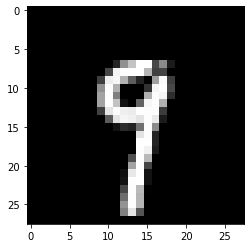

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000

In [ ]:
for i, x in enumerate(dataloader):
    plt.imshow(x[0][0].reshape(28,28), cmap="gray")
    plt.show()
    print(x[0][0].reshape(28,28))
    break

### Generator & Discriminator

In [6]:
# random distribution 의 dim 은 100으로 설정
z_size = 100

# Discriminator 와 같은역할,
# 저차원 데이터를 고차원으로 만들어 준다, 이때 최종 dim 은 이미지를 따라 28*28 로 설정

# input으로 noise를 넣어줘야함
class Generator(nn.Module):
    def __init__(self, z_size):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(z_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2) # negative slope = 0.2
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        
        return torch.tanh(self.fc4(x))

In [7]:
# 입력받은 이미지가 진짜인지 가짜인지 판별

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        
        # 마지막으로 0~1 사이의 값을 내보내도록 sigmoid 를 거쳐준다
        # 0 혹은 1 로 나타내지 않고 0~1 사이의 연속된 수로 나타내는 이유는 Discriminator 가 얼마나 확신을 가지고 있는지
        # 알기 위해서 이다. output 값이 0.5 가 나왓다면 진짜인지 가짜인지 헷갈리는 것과 같은 의미이고 0.7이면 70%를 맞추었다는 뜻
        # 이러한 '확신' 을 반영하기 위해 0~1 사이의 Continous 한 값을 output 으로 준다
        return torch.sigmoid(self.fc4(x))

In [8]:
netG = Generator(z_size).to(device)
netD = Discriminator().to(device)

### Make Fake image without any training
아무런 트레이닝을 하지 않은 상태에서 noise 를 만들고 Generator 에 넣어보자

In [9]:
just_noise = torch.randn(1, z_size).to(device)
just_noise

tensor([[ 1.4571e-01, -9.5486e-01, -2.2098e+00,  9.1558e-01,  1.9904e-01,
         -1.5794e+00,  9.1039e-01, -1.4777e+00, -1.5413e-02,  3.2882e-01,
          7.7570e-01, -2.3076e-02, -9.0072e-01,  6.8419e-01,  2.5686e-01,
          5.9574e-01,  9.7688e-01,  7.2383e-01,  8.1437e-01, -4.3673e-01,
          4.6244e-01, -1.4429e+00,  1.2850e+00, -1.7560e+00, -1.8305e-01,
          2.2926e+00, -5.8423e-01,  3.0623e-01, -1.5593e+00,  1.0030e+00,
          5.6933e-01,  1.2483e+00, -1.9886e+00,  3.1449e-01,  6.5555e-02,
          8.2775e-01,  5.8325e-01,  8.0647e-01,  8.5364e-01,  5.1402e-01,
         -4.0973e-01,  3.2168e-01, -1.1386e+00, -6.5678e-02,  6.5750e-01,
          8.2215e-01,  1.0772e+00,  1.7221e+00,  2.5971e-01, -1.0268e+00,
          3.2129e-01, -2.7609e+00, -1.0071e+00,  2.6707e+00,  1.0168e+00,
          2.5279e+00, -1.2896e+00, -2.2199e-01,  7.7904e-01, -1.3035e+00,
          2.6523e+00,  1.3833e+00,  1.0612e+00,  5.0237e-01,  1.4990e-01,
          2.7825e+00,  1.2172e+00,  9.

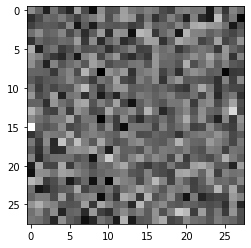

In [10]:
# Generator 를 이용해서 생성
img_fake = netG(just_noise).reshape(28,28)
# 이미지 출력하기
plt.imshow(img_fake.cpu().detach().numpy(), cmap = 'gray')

예상대로 training 을 거치지 않았으므로 noise 가 생성된다

### 그 밖의 Setting 들

In [ ]:
num_epochs = 15
lr = 0.0002

loss_function = nn.BCELoss()

In [ ]:
# Noise 하나를 fix 시켜서 변수에 담아준다. 학습을 하면서 생성되는 image 의 변화를 관찰 할 수 있다
# fixed_noise 라는 변수는 epoch 단위로 학습이 끝날때마다 netG(Generator) 안으로 들어가서 어떠한 이미지를 generation 할 것이다
# 그것을 순서대로 담아서 앞에서부터 출력해주면 똑같은 noise 가 epoch 가 진행될 수록 어떻게 image 형태가 잘 나오는지의
# 변화를 볼 수 있다
# epoch가 늘어날 때마다 점점 성능이 나아져야하므로 이 경우에는 숫자가 나타나야함

fixed_noise = torch.randn(64, z_size).to(device)

In [ ]:
# Discriminator 가 real 혹은 false 로 판단할 수 있게끔 scalar 값으로 labeling을 해준다
# 여기에 설정해둔 값으로 loss 를 구하게 된다
real_label = 1
fake_label = 0

In [ ]:
# optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

### Training

In [ ]:
# 생성되는 이미지를 저장할 빈 리스트
img_list = []

# loss 값을 저장할 빈 리스트
G_losses = []
D_losses = []

GAN 의 original 논문과 함께 Discriminator 를 먼저 학습한 후 Generator 를 학습한다

In [ ]:
# minibatch 가 몇번 학습했는지를 나타내는 총 itertaion 을 계산
# 즉, batch size 는 100이고 데이터의 총 갯수는 60000개 이므로 iteration 은 600 이다.
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader): # 기존에는 i 를 batch_idx 로 해주고 data 를 (image, label) 로 하였음
        
        ###################################################################################################################
        # =================================================================== #
        # (1) Update Discriminator
        # [LogD(x) + Log(1-D(G(z)))]
        # =================================================================== #
        
        #####################################################
        # 1. Real Image 로 Discriminator 훈련 (LogD(x) 부분)
        # LogD(x) 를 1로 판단 할 수 있어야 한다
        #####################################################
        netD.zero_grad()
        
        # data[0] = image data 를 나타냄
        # data[1] = image label 을 나타냄
        # real_cpu = real 그림 이미지를 나타내는 변수
        real_cpu = data[0].to(device)
        
        b_size = real_cpu.size(0) # real_cpu.shape[0] 과 같은 의미 / 즉, torch.Size([100, 1, 28, 28]) 에서 100을 말함
        real_cpu = data[0].reshape(b_size, -1).to(device) # 28*28을 784로 풀어주기 위한 코드
        # FC layer 이므로 한줄로 좌라락 풀어준다 / 즉, torch.Size([100, 784])
        
        # label 의 경우 torch 형태로 (1,1,1,1,1,1,1, ... 이 batch size 만큼 들어가있다 (discriminator 와 결과와 비교하기 위해))
        label = torch.full((b_size,), real_label, dtype=torch.float32).to(device)
        # print(label) 해보면 아래와 같이 나옴
        """
        tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
                1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
        """

        output = netD(real_cpu).view(-1).to(device) # torch.Size([100, 1]) => output.shape 이므로 view(-1 을 해서 Size[100] 으로 변환)
        
        """
        Loss function 은 BCE 이다. 또한 y 값은 1로 고정이 되어있다 (true data 이므로)
        BCE 의 공식에 y = 1 을 넣으면 뒤의 항은 0이 되어서 사라지게 되고 앞의 항 LogD(x) 만 남게된다
        """
        errD_real = loss_function(output, label) # => LogD(x)
        
        # real image 에 대한 back propagation
        errD_real.backward()
        D_x = output.mean().item()  # mini batch 마다 D(x) 의 평균값을 구하기 위해 D_x 에 따로 저장

        ######################################
        # 2. Fake Image 로 Discriminator 훈련
        ######################################
        
        # Generator 에 들어갈 noise 생성
        noise = torch.randn(b_size, z_size).to(device) # 배치 size, noise size
        
        # Generate 에서 fake image 생성 (Discriminator 가 분간해야 하는 image) -> 전부 0이라고 구분해야 정상이다
        fake = netG(noise).to(device)
        
        # 위에서 미리 만들어둔 label 을 이번에는 0,0,0,0,0,0,...으로 채워준다
        label.fill_(fake_label).to(device)
        
        # Noise 를 Discriminator에 넣어보자
        # .detach() 가 필수로 들어가야 한다 (이미 netD 를 한번 사용 했으므로)
        '''
        # (https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-
        # but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time-
        # while-using-custom-loss-function/12360/2)
        
        # 두번 쓸 때 detach를 꼭 사용해야 output을 나타낼 수 있음 (반복되는 구간이 있을 때 사용)
        # ex. LSTM...
        '''

        output = netD(fake.detach()).view(-1).to(device) # Fake data 입력
        # detach 사용 필수
        errD_fake = loss_function(output, label) # 이번에는 Y 가 0 이므로 log(1-D(G(z))) 가 남게 된다

        errD_fake.backward() # back propagation
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake # Discriminator 의 Error 를 구해보자
        
        # Update Discriminator
        optimizerD.step()
        ###################################################################################################################
        
        
        
        
        ###################################################################################################################
        # =================================================================== #
        # (2) Update Generator
        #  [LogD(G(z))] 
        # =================================================================== #
        # Generator 는 만들어낸 image 가 discriminator 로 하여금 1 (real) 로 판단 할 수 있게 훈련시켜야 한다
        netG.zero_grad()
        label.fill_(real_label)  # 아까 위에 있는 line 과 마찬가지 / 이번에는 1로 채워넣는다 (진짜라고 착각하게 만들어야하므로)
        
        # Generator 가 만든 fake_image 를 Discriminator 에 넣어서 학습
        output = netD(fake).view(-1).to(device) # 63 line 에서 만든 fake 를 그대로 가져옴, 같은 fake image 를 가지고 해야 학습이 공평하다.
        
        errG = loss_function(output, label)  # y=1 이므로 log(D(G(z))) 가 된다 (in Practice 부분)

        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()
        
        # Training 경과를 관찰하기 위해 print
        if i % 200 == 0:
            # Print 문을 사용해서 어떤것을 출력하는 걸까?
            # [현재 epoch/전체 epoch][현재 iteration/전체 itertation]
            # Discriminator 의 loss, D(Real_image), D 를 훈련하기 전의 D(fake), D 를 훈련한 후의 D(fake)
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Plotting 을 하기 위해서 list 에 loss 값을 넣어준다
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # 또한 iteration 을 돌리면서 중간중간 생성되는 image 값을 저장하여 결과를 지켜보도록하자
        # ((epoch == num_epochs-1) and (batch_size == len(trainloader)-1))
        #   → 가장 마지막 epoch 에서 가장 마지막 minibatch 를 학습할 때의 시점 (맨 마지막 학습 결과)
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu() # netG 를 다시 사용해야 하므로 detach 를 붙여줌
                fake = fake.reshape(-1,1,28,28)
            img_list.append(vutils.make_grid(fake, normalize=True)) # If normalize=True, shift the image to the range (0, 1)
            
        iters += 1
        # GAN은 한번만에 좋은 성능을 내지 못함 어느정도 훈련이 잘 되도록 여러번 돌려야 성능이 잘 나오게 됨
        # 이미지를 잘 생성하는지를 평가해야 함

Starting Training Loop...
[0/15][0/600]	Loss_D: 1.3878	Loss_G: 0.6751	D(x): 0.5083	D(G(z)): 0.5088 / 0.5091
[0/15][200/600]	Loss_D: 0.6730	Loss_G: 1.4275	D(x): 0.8807	D(G(z)): 0.4122 / 0.2421
[0/15][400/600]	Loss_D: 0.3400	Loss_G: 3.0494	D(x): 0.8914	D(G(z)): 0.1704 / 0.0534
[1/15][0/600]	Loss_D: 1.2071	Loss_G: 1.3848	D(x): 0.4961	D(G(z)): 0.0353 / 0.2748
[1/15][200/600]	Loss_D: 0.3682	Loss_G: 3.2172	D(x): 0.8622	D(G(z)): 0.0939 / 0.0660
[1/15][400/600]	Loss_D: 0.2968	Loss_G: 3.2846	D(x): 0.8536	D(G(z)): 0.0437 / 0.0603
[2/15][0/600]	Loss_D: 1.2874	Loss_G: 1.7578	D(x): 0.5638	D(G(z)): 0.0130 / 0.2469
[2/15][200/600]	Loss_D: 0.3709	Loss_G: 3.0278	D(x): 0.8789	D(G(z)): 0.1572 / 0.0657
[2/15][400/600]	Loss_D: 0.2423	Loss_G: 3.0369	D(x): 0.9368	D(G(z)): 0.1341 / 0.0666
[3/15][0/600]	Loss_D: 0.3808	Loss_G: 3.5244	D(x): 0.9009	D(G(z)): 0.1864 / 0.0446
[3/15][200/600]	Loss_D: 0.2626	Loss_G: 2.9218	D(x): 0.8803	D(G(z)): 0.0516 / 0.0817
[3/15][400/600]	Loss_D: 0.3496	Loss_G: 3.2275	D(x): 0.9092

### Save files

In [ ]:
# image list 를 pt 로 저장
torch.save(img_list, './torch_save/GAN_01_FeedForward_GAN_epoch'+str(num_epochs) +'.pt')

# G 를 앞으로 사용할 수 있게 저장
torch.save(netG.state_dict(), './pre_trained/GAN_01_FeedForward_GAN_epoch'+str(num_epochs) +'.pth')

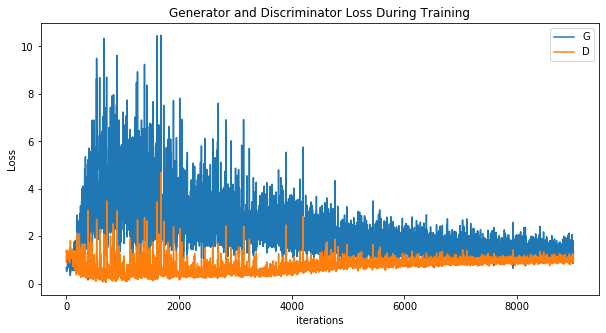

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Real image 와 fake image 를 한눈에 살펴보자

In [ ]:
img_list = torch.load('./torch_save/GAN_01_FeedForward_GAN_epoch'+str(num_epochs) +'.pt', map_location  = device)

In [ ]:
# real image 를 담을 list 를 준비 & image 담기
sample_image = []
for i, data in enumerate(dataloader):
    sample_image.append(data[0][range(64)]) # 첫번째 mini batch 에 들어있는 image 중 앞에서부터 순서대로 64개의 image 를 담아줌
    break

##### Plot images

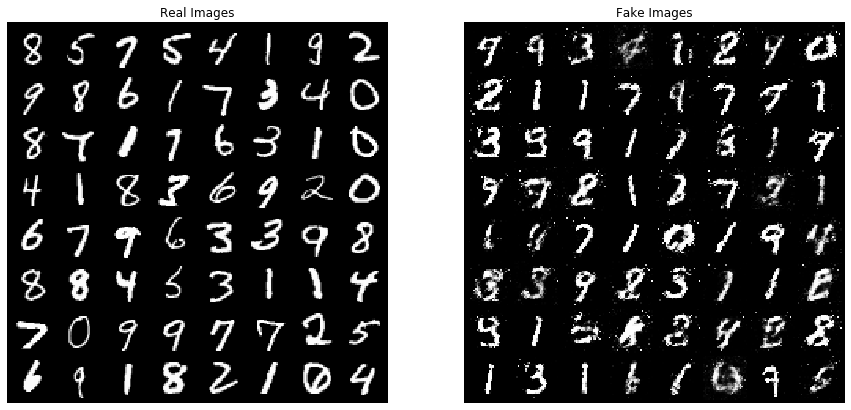

In [ ]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_image[0], normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")

plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))

plt.show()

### Load Model

In [ ]:
netG = Generator(100).to(device) # random distribution 의 dim 은 100으로 설정했으므로 100 을 넣어야한다

In [ ]:
netG.load_state_dict(torch.load('./pre_trained/GAN_01_FeedForward_GAN_epoch' + str(num_epochs) +'.pth',  map_location=device))

<All keys matched successfully>

### Generate amy images

In [ ]:
z_noise = torch.randn(5, z_size).to(device)
image = netG(z_noise).cpu()

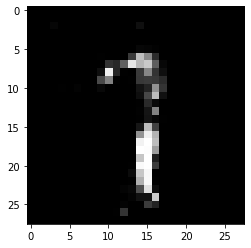

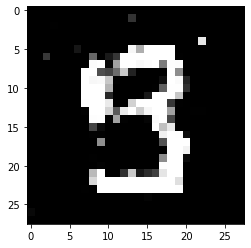

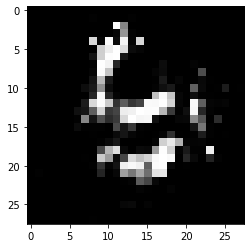

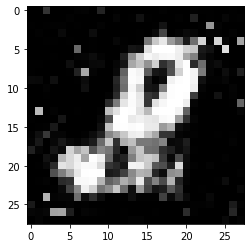

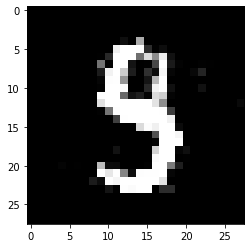

In [ ]:
for generated in (image):
    plt.imshow(generated.detach().numpy().reshape(28,28), cmap="gray")
    plt.show()